In [76]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value


# Import Data and Mini EDA

In [82]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [83]:
df.drop(columns=["Name", 'Ticket', 'Age', 'Cabin'], inplace=True)

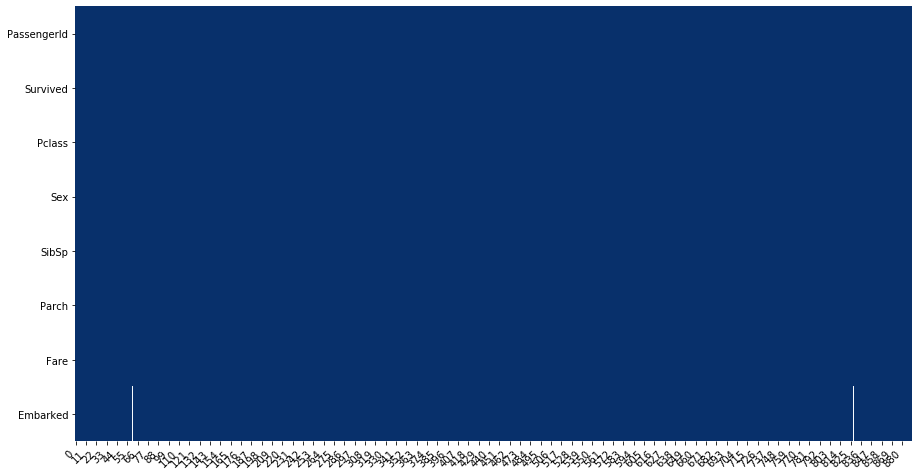

In [84]:
plot_missing_value(df)

In [85]:
df['Embarked'].fillna('S', inplace=True)

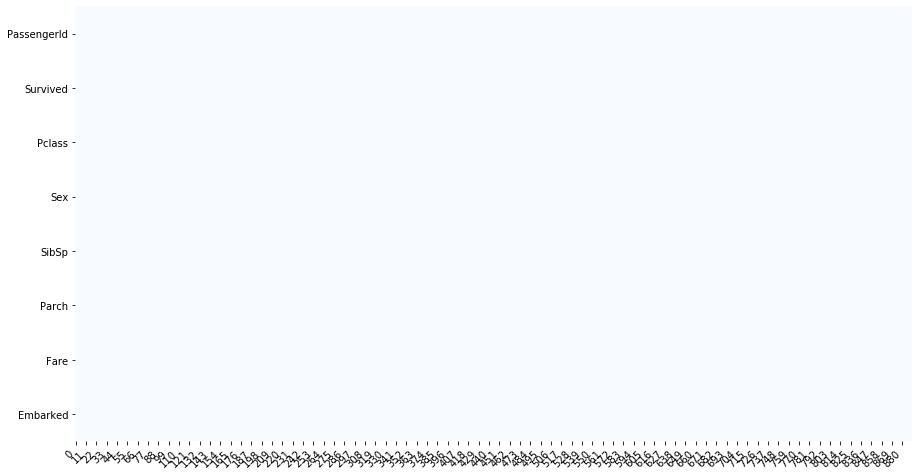

In [86]:
plot_missing_value(df)

# Dataset Splitting

In [87]:
X = df.drop(columns="Survived")
y = df.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 7), (179, 7), (712,), (179,))

# Pipeline Preprocessor

In [88]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["SibSp", "Parch", "Fare"]),
    ('categoric', cat_pipe(encoder='onehot'), ["Pclass", "Sex", "Embarked"]),
])

from xgboost import XGBClassifier
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

# Model

In [89]:
model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s


{'algo__colsample_bytree': 0.6439756413500356, 'algo__gamma': 4, 'algo__learning_rate': 0.7686119654652775, 'algo__max_depth': 7, 'algo__n_estimators': 158, 'algo__reg_alpha': 0.601367193359287, 'algo__reg_lambda': 3.325610295975196, 'algo__subsample': 0.6121770240668967}
0.8258426966292135 0.8104043305085747 0.8156424581005587


[Parallel(n_jobs=-1)]: Done 143 out of 150 | elapsed:    4.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.3s finished


# Predict

In [77]:
from IPython.display import Image

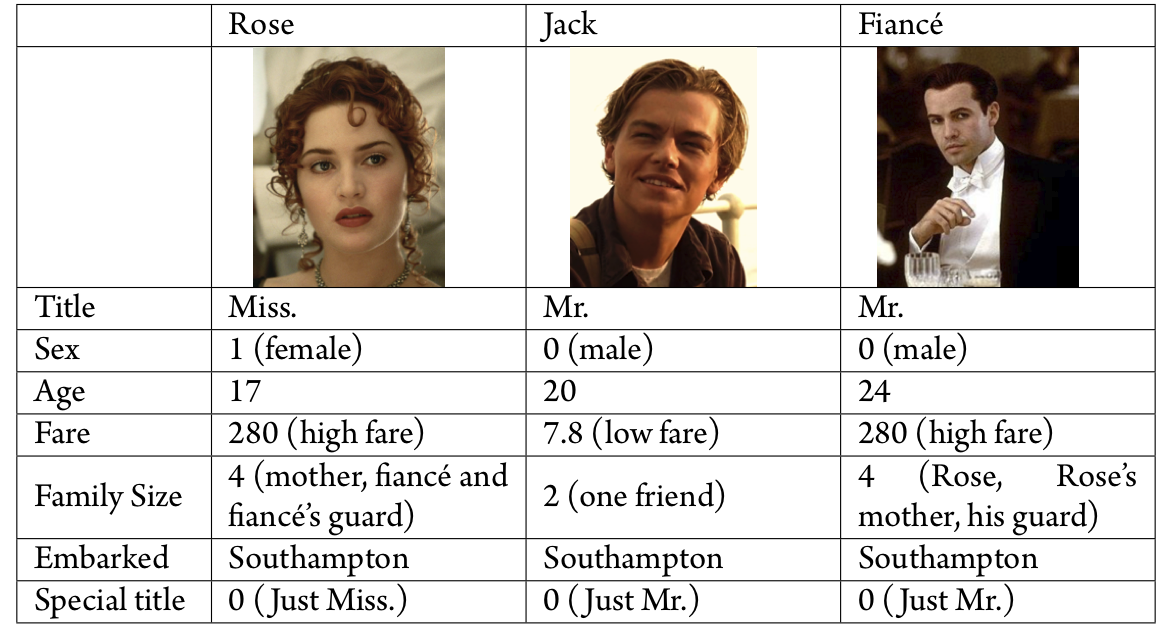

In [80]:
Image("titanic.png")

Survive = 1
Not Survive = 0

In [107]:
data = [
    [1, 4, 'female', 1, 1, 280, "S"],
    [2, 0, 'male', 0, 0, 7, "S"],
    [3, 4, 'male', 1, 0, 280, "S"]
    ] 

X_pred = pd.DataFrame(data, index=["Rose", "Jack", "Fiance"], columns=X.columns)
X_pred['Survived'] = model.predict(X_pred)
X_pred

,PassengerId,Pclass,Sex,SibSp,Parch,Fare,Embarked,Survived
Rose,1,4,female,1,1,280,S,1
Jack,2,0,male,0,0,7,S,0
Fiance,3,4,male,1,0,280,S,0
